<a href="https://colab.research.google.com/github/akinahomwabella/Bias_Detection_SLM/blob/main/fair_ml_pipeline.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#Import and load libraries
!pip install lime
!pip install fairlearn
!pip install transformers accelerate
!pip install transformers accelerate bitsandbytes
!pip install --upgrade tensorflow
!pip install --upgrade tf_keras
!pip install --upgrade transformers
!pip install --upgrade shap
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix,accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from xgboost import XGBClassifier
from sklearn.tree import DecisionTreeClassifier
from lime.lime_tabular import LimeTabularExplainer
from sklearn.utils.class_weight import compute_sample_weight
from fairlearn.reductions import ExponentiatedGradient, EqualizedOdds
from sklearn.linear_model import LogisticRegression
from transformers import AutoTokenizer, AutoModelForCausalLM
from fairlearn.reductions import ExponentiatedGradient, EqualizedOdds, DemographicParity, GridSearch
from fairlearn.metrics import MetricFrame, selection_rate, demographic_parity_difference, equalized_odds_difference
from fairlearn.preprocessing import CorrelationRemover
from sklearn.ensemble import RandomForestClassifier
import numpy as np
import shap
import random
import lime
import lime.lime_tabular
import torch
import joblib

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.7/275.7 kB 4.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for lime: filename=lime-0.2.0.1-py3-none-any.whl size=283834 sha256=a703488a1b66be2621a38b644c03b74b62422e365d9cc3a2a17545e10f19f5a8
  Stored in directory: /root/.cache/pip/wheels/85/fa/a3/9c2d44c9f3cd77cf4e533b58900b2bf4487f2a17e8ec212a3d
Successfully built lime
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 240.0/240.0 kB 3.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 94.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 49.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 41.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 7.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [2]:
#Mount the drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
path="/content/drive/MyDrive/NCUR"
if os.path.exists(path):
  files=[file for file in os.listdir(path) if not file.startswith('.')]
  for file in files:
    print(file)
else:
  print("Path doesn't exist")

adult.csv
compas-scores-two-years-violent.csv


In [4]:
# Load each dataset separately
#This dataset will be on the COMPAS dataset
df_compas = pd.read_csv('/content/drive/MyDrive/NCUR/compas-scores-two-years-violent.csv')
df_compas.head()


,id,name,first,last,compas_screening_date,sex,dob,age,age_cat,race,...,v_score_text,v_screening_date,in_custody,out_custody,priors_count.1,start,end,event,two_year_recid,two_year_recid.1
0,1,miguel hernandez,miguel,hernandez,2013-08-14,Male,1947-04-18,69,Greater than 45,Other,...,Low,2013-08-14,2014-07-07,2014-07-14,0,0,327,0,0,0
1,3,kevon dixon,kevon,dixon,2013-01-27,Male,1982-01-22,34,25 - 45,African-American,...,Low,2013-01-27,2013-01-26,2013-02-05,0,9,159,1,1,1
2,5,marcu brown,marcu,brown,2013-01-13,Male,1993-01-21,23,Less than 25,African-American,...,Medium,2013-01-13,NaN,NaN,1,0,1174,0,0,0
3,6,bouthy pierrelouis,bouthy,pierrelouis,2013-03-26,Male,1973-01-22,43,25 - 45,Other,...,Low,2013-03-26,NaN,NaN,2,0,1102,0,0,0
4,7,marsha miles,marsha,miles,2013-11-30,Male,1971-08-22,44,25 - 45,Other,...,Low,2013-11-30,2013-11-30,2013-12-01,0,1,853,0,0,0


In [5]:
#Clean the COMPAS dataset next(this is more info to understand which one are relevant)
df_compas.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4743 entries, 0 to 4742
Data columns (total 54 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   id                       4743 non-null   int64  
 1   name                     4743 non-null   object 
 2   first                    4743 non-null   object 
 3   last                     4743 non-null   object 
 4   compas_screening_date    4743 non-null   object 
 5   sex                      4743 non-null   object 
 6   dob                      4743 non-null   object 
 7   age                      4743 non-null   int64  
 8   age_cat                  4743 non-null   object 
 9   race                     4743 non-null   object 
 10  juv_fel_count            4743 non-null   int64  
 11  decile_score             4743 non-null   int64  
 12  juv_misd_count           4743 non-null   int64  
 13  juv_other_count          4743 non-null   int64  
 14  priors_count            

In [6]:
#More understanding on it to see which one equally skewed
df_compas.describe(include='all')

,id,name,first,last,compas_screening_date,sex,dob,age,age_cat,race,...,v_score_text,v_screening_date,in_custody,out_custody,priors_count.1,start,end,event,two_year_recid,two_year_recid.1
count,4743.000000,4743,4743,4743,4743,4743,4743,4743.000000,4743,4743,...,4743,4743,4534,4534,4743.000000,4743.000000,4743.000000,4743.000000,4743.000000,4743.000000
unique,NaN,4721,2114,2897,586,2,3978,NaN,3,6,...,3,586,1003,1012,NaN,NaN,NaN,NaN,NaN,NaN
top,NaN,james adams,michael,williams,2013-09-23,Male,1989-08-31,NaN,25 - 45,African-American,...,Low,2013-09-23,2014-01-04,2020-01-01,NaN,NaN,NaN,NaN,NaN,NaN
freq,NaN,2,95,49,24,3746,4,NaN,2699,2266,...,3389,24,19,27,NaN,NaN,NaN,NaN,NaN,NaN
mean,5454.230445,NaN,NaN,NaN,NaN,NaN,NaN,36.002952,NaN,NaN,...,NaN,NaN,NaN,NaN,2.677209,9.084124,730.143369,0.165507,0.163399,0.163399
std,3189.515451,NaN,NaN,NaN,NaN,NaN,NaN,12.200715,NaN,NaN,...,NaN,NaN,NaN,NaN,4.084277,36.867544,365.435158,0.371677,0.369768,0.369768
min,1.000000,NaN,NaN,NaN,NaN,NaN,NaN,18.000000,NaN,NaN,...,NaN,NaN,NaN,NaN,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000
25%,2631.000000,NaN,NaN,NaN,NaN,NaN,NaN,26.000000,NaN,NaN,...,NaN,NaN,NaN,NaN,0.000000,0.000000,422.500000,0.000000,0.000000,0.000000
50%,5475.000000,NaN,NaN,NaN,NaN,NaN,NaN,33.000000,NaN,NaN,...,NaN,NaN,NaN,NaN,1.000000,0.000000,837.000000,0.000000,0.000000,0.000000
75%,8239.500000,NaN,NaN,NaN,NaN,NaN,NaN,44.000000,NaN,NaN,...,NaN,NaN,NaN,NaN,3.000000,1.000000,1039.000000,0.000000,0.000000,0.000000


In [7]:
#Clean the compas dataset
#Removing any column that is not needed
columns_to_drop = [
    'id', 'name', 'first', 'last', 'dob', 'violent_recid',
    'decile_score.1', 'priors_count.1', 'two_year_recid.1',
    'screening_date', 'v_screening_date', 'start', 'end', 'days_b_screening_arrest', 'c_days_from_compas', 'r_days_from_compas', 'c_days_b_screening', 'r_days_b_screening',
    'c_charge_degree', 'r_charge_degree', 'vr_charge_degree',
    'c_case_number', 'r_case_number', 'vr_case_number',
    'c_arrest_date', 'c_offense_date', 'r_offense_date', 'vr_offense_date',
    'c_jail_in', 'c_jail_out', 'r_jail_in', 'r_jail_out',
    'c_charge_desc', 'r_charge_desc', 'vr_charge_desc','compas_screening_date','age_cat','v_type_of_assessment','in_custody','out_custody','score_text','type_of_assessment','v_score_text','v_decile_score','event','is_violent_recid','is_recid',
]

# Remove whitespace(this helps if there is any space )
df_compas.columns = df_compas.columns.str.strip()
columns_to_drop = [col.strip() for col in columns_to_drop]


df_compas = df_compas.drop(columns=columns_to_drop, errors='ignore')

# Drop columns with too many NaNs:
df_compas = df_compas.dropna(axis=1, thresh=1000)

In [8]:
#Check whether the compas has duplicate or not
df_compas.duplicated().sum()

np.int64(1208)

In [9]:
#Drop the duplicates for the compas datsset
df_compas = df_compas.drop_duplicates()
df_compas.duplicated().sum()

np.int64(0)

In [10]:
df_compas.to_csv('cleaned_compas.csv',index=False)
df_compas_cleaned = df_compas.copy() # work on this copy

In [ ]:
df_compas_cleaned.info()
df_compas_cleaned.describe(include="all")

In [11]:
#Encoding the COMPAS dataset next
# map the encoding to figure out which method we will use during fairness analysis
race_mapping = {
    'African-American': 0,
    'Asian': 1,
    'Caucasian': 2,
    'Hispanic': 3,
    'Native American': 4,
    'Other': 5
}
sex_mapping = {'Female': 0, 'Male':1 }
#Add the encoded program into the dataset
df_compas_cleaned['race_encoded'] = df_compas_cleaned['race'].map(race_mapping)
df_compas_cleaned['sex_encoded'] = df_compas_cleaned['sex'].map(sex_mapping)



#Save a csv with an encoded dataset
df_compas_cleaned.to_csv('encoded_compas.csv', index=False)
df_compas_encoded = df_compas_cleaned.copy()
df_compas_encoded.head()

,sex,age,race,juv_fel_count,decile_score,juv_misd_count,juv_other_count,priors_count,two_year_recid,race_encoded,sex_encoded
0,Male,69,Other,0,1,0,0,0,0,5,1
1,Male,34,African-American,0,3,0,0,0,1,0,1
2,Male,23,African-American,0,8,1,0,1,0,0,1
3,Male,43,Other,0,1,0,0,2,0,5,1
4,Male,44,Other,0,1,0,0,0,0,5,1


In [12]:
#Check if they are actually encoded or not
df_compas_encoded['sex_encoded'].unique()

array([1, 0])

In [13]:
df_compas_encoded['race_encoded'].unique()

array([5, 0, 2, 3, 1, 4])

In [14]:
#Split the dataset into to train and test split
#Perform logisitc regression on compas dataset
X_compas=df_compas_encoded.drop(columns=['two_year_recid','race','sex'])
Y_compas=df_compas_encoded['two_year_recid']
X_train_compas, X_test_compas, Y_train_compas, Y_test_compas = train_test_split(X_compas, Y_compas, test_size=0.2, random_state=42, stratify=Y_compas)
model_lr=LogisticRegression(max_iter=1000)
model_lr.fit(X_train_compas,Y_train_compas)
y_pred_lg=model_lr.predict(X_test_compas)
#Evaluate the performance
print("The performance of Logistic regression ")
print(classification_report(Y_test_compas,y_pred_lg))
print(confusion_matrix(Y_test_compas,y_pred_lg))


The performance of Logistic regression 
              precision    recall  f1-score   support

           0       0.80      0.98      0.88       558
           1       0.59      0.11      0.18       149

    accuracy                           0.80       707
   macro avg       0.70      0.54      0.53       707
weighted avg       0.76      0.80      0.74       707

[[547  11]
 [133  16]]


In [15]:
#Perform random forest classifier(try another model too to see which one is better)
model_rf = RandomForestClassifier(random_state=42)
model_rf.fit(X_train_compas, Y_train_compas)
y_pred_rf = model_rf.predict(X_test_compas)
print("The performance of Random Forest Classifier")
#Evaluate the performance
print(classification_report(Y_test_compas,y_pred_rf))
print(confusion_matrix(Y_test_compas,y_pred_rf))


The performance of Random Forest Classifier
              precision    recall  f1-score   support

           0       0.80      0.88      0.84       558
           1       0.29      0.18      0.22       149

    accuracy                           0.73       707
   macro avg       0.55      0.53      0.53       707
weighted avg       0.69      0.73      0.71       707

[[492  66]
 [122  27]]


In [16]:
#Perform fairness analysis
import pandas as pd

# Function to compute fairness metrics for a subgroup
def compute_metrics(df, sensitive_column, sensitive_value):

    group = df[df[sensitive_column] == sensitive_value]

    # Calculate confusion matrix components
    TP = ((group['true'] == 1) & (group['pred'] == 1)).sum()
    TN = ((group['true'] == 0) & (group['pred'] == 0)).sum()
    FP = ((group['true'] == 0) & (group['pred'] == 1)).sum()
    FN = ((group['true'] == 1) & (group['pred'] == 0)).sum()

    # Calculate metrics, using conditionals to avoid division by zero
    fpr = FP / (FP + TN) if (FP + TN) > 0 else None
    fnr = FN / (FN + TP) if (FN + TP) > 0 else None
    tnr = TN / (TN + FP) if (TN + FP) > 0 else None
    tpr = TP / (TP + FN) if (TP + FN) > 0 else None

    return {'FPR': fpr, 'FNR': fnr, 'TNR': tnr, 'TPR': tpr}


# Prepare test set copy with sensitive attributes
# Assuming X_test_compas is test features and df_compas_cleaned is original sensitive

X_test_compas_copy = X_test_compas.copy()
X_test_compas_copy['true'] = Y_test_compas
X_test_compas_copy['pred'] = y_pred_rf

# Re-attach sensitive attributes from the cleaned dataframe
X_test_compas_copy['race'] = df_compas_cleaned.loc[X_test_compas.index, 'race']
X_test_compas_copy['sex'] = df_compas_cleaned.loc[X_test_compas.index, 'sex']

#Compute metrics for each group by sex
print("Fairness Metrics by Sex:")
sex_groups = X_test_compas_copy['sex'].unique()
metrics_by_sex = {}
for sex in sex_groups:
    metrics_by_sex[sex] = compute_metrics(X_test_compas_copy, 'sex', sex)
    print(f"{sex}: {metrics_by_sex[sex]}")

#Compute metrics for each group by race
print("\nFairness Metrics by Race:")
race_groups = X_test_compas_copy['race'].unique()
metrics_by_race = {}
for race in race_groups:
    metrics_by_race[race] = compute_metrics(X_test_compas_copy, 'race', race)
    print(f"{race}: {metrics_by_race[race]}")

# Additional Analysis
# The proportion of false positives by race:
fp_by_race = X_test_compas_copy[(X_test_compas_copy['true'] == 0) & (X_test_compas_copy['pred'] == 1)].race.value_counts(normalize=True)
fn_by_race = X_test_compas_copy[(X_test_compas_copy['true'] == 1) & (X_test_compas_copy['pred'] == 0)].race.value_counts(normalize=True)

print("\nFalse Positives by Race:")
print(fp_by_race)
print("\nFalse Negatives by Race :")
print(fn_by_race)

# Similarly, for sex:
fp_by_sex = X_test_compas_copy[(X_test_compas_copy['true'] == 0) & (X_test_compas_copy['pred'] == 1)].sex.value_counts(normalize=True)
fn_by_sex = X_test_compas_copy[(X_test_compas_copy['true'] == 1) & (X_test_compas_copy['pred'] == 0)].sex.value_counts(normalize=True)

print("\nFalse Positives by Sex :")
print(fp_by_sex)
print("\nFalse Negatives by Sex :")
print(fn_by_sex)


Fairness Metrics by Sex:
Female: {'FPR': np.float64(0.04), 'FNR': np.float64(1.0), 'TNR': np.float64(0.96), 'TPR': np.float64(0.0)}
Male: {'FPR': np.float64(0.14705882352941177), 'FNR': np.float64(0.7938931297709924), 'TNR': np.float64(0.8529411764705882), 'TPR': np.float64(0.20610687022900764)}

Fairness Metrics by Race:
African-American: {'FPR': np.float64(0.14760147601476015), 'FNR': np.float64(0.7608695652173914), 'TNR': np.float64(0.8523985239852399), 'TPR': np.float64(0.2391304347826087)}
Caucasian: {'FPR': np.float64(0.10106382978723404), 'FNR': np.float64(0.9428571428571428), 'TNR': np.float64(0.898936170212766), 'TPR': np.float64(0.05714285714285714)}
Other: {'FPR': np.float64(0.0), 'FNR': np.float64(0.75), 'TNR': np.float64(1.0), 'TPR': np.float64(0.25)}
Hispanic: {'FPR': np.float64(0.11320754716981132), 'FNR': np.float64(0.9230769230769231), 'TNR': np.float64(0.8867924528301887), 'TPR': np.float64(0.07692307692307693)}
Native American: {'FPR': np.float64(0.5), 'FNR': None, '

 93%|=================== | 1314/1414 [00:18<00:01]       

SHAP values for class 1 shape: (707, 8)


<ipython-input-17-7c5a0bb59a58>:23: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(x='feature', y='shap_value', data=shap_melted_compas, ci=None)


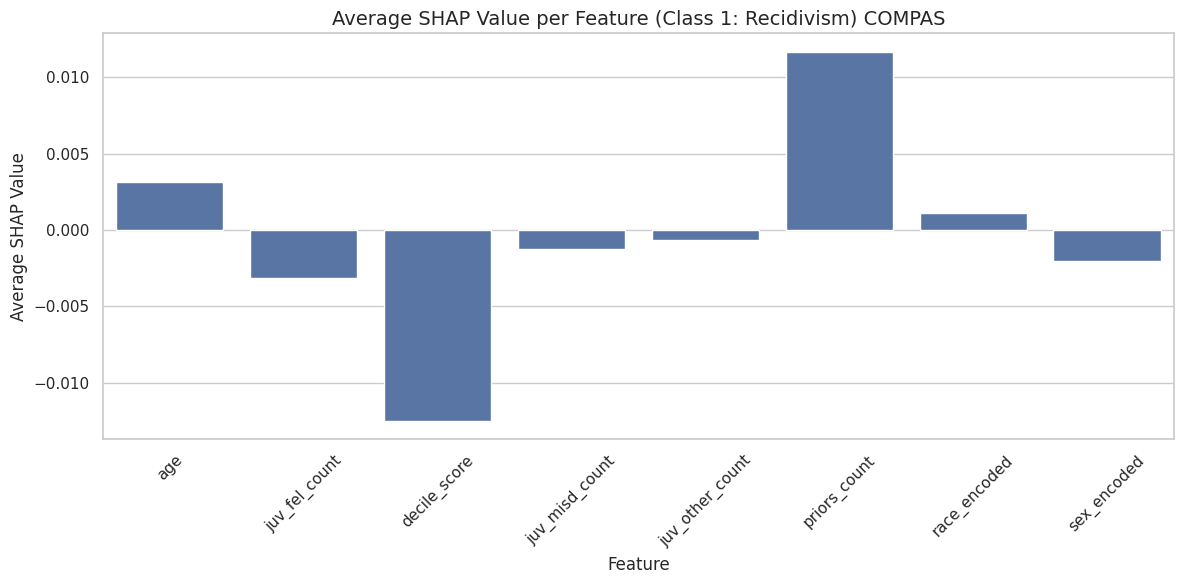

In [17]:
#SHAP value for COMPAS_dataset
# Sample background data from training set
background = X_train_compas.sample(30, random_state=42)

# Initialize TreeExplainer with background data
explainer = shap.TreeExplainer(model_rf, data=background, model_output='probability')
shap_values = explainer.shap_values(X_test_compas)

# Extract the SHAP values for class 1 (Recidivism) for all samples
shap_values_class1 = np.array([sv[:, 1] for sv in shap_values])
print("SHAP values for class 1 shape:", shap_values_class1.shape)

# Convert the extracted SHAP values to a dataframe with the same columns as X_test_compas
shap_df_compas= pd.DataFrame(shap_values_class1, columns=X_test_compas.columns)
shap_df_compas['sample_id'] = shap_df_compas.index

# Melt the DataFrame into long format for plotting
shap_melted_compas= shap_df_compas.melt(id_vars='sample_id', var_name='feature', value_name='shap_value')

# Plot a bar plot of the SHAP values for each feature
plt.figure(figsize=(12, 6))
sns.set(style="whitegrid")
sns.barplot(x='feature', y='shap_value', data=shap_melted_compas, ci=None)

plt.title('Average SHAP Value per Feature (Class 1: Recidivism) COMPAS', fontsize=14)
plt.xlabel('Feature', fontsize=12)
plt.ylabel('Average SHAP Value', fontsize=12)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [18]:
#Use LIME Explainer
import random
from lime.lime_tabular import LimeTabularExplainer

# Create an instance
explainer = LimeTabularExplainer(
    training_data=np.array(X_train_compas),
    feature_names=X_train_compas.columns.tolist(),
    class_names=['No Recidivism', 'Recidivism'],
    mode='classification'
)
#List to collect data
lime_data=[]
# Loop through 30 random samples from X_test_compas
for i in random.sample(range(len(X_test_compas)), 30):
    exp = explainer.explain_instance(
        data_row=X_test_compas.iloc[i],
        predict_fn=model_rf.predict_proba,
        num_features=5
    )
    for feature,weight in exp.as_list():
        lime_data.append([i,feature,weight])

# Convert to DataFrame
lime_df = pd.DataFrame(lime_data, columns=['sample_id', 'feature', 'lime_weight'])



/usr/local/lib/python3.11/dist-packages/lime/discretize.py:110: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/usr/local/lib/python3.11/dist-packages/lime/discretize.py:110: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/usr/local/lib/python3.11/dist-packages/lime/lime_tabular.py:544: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.

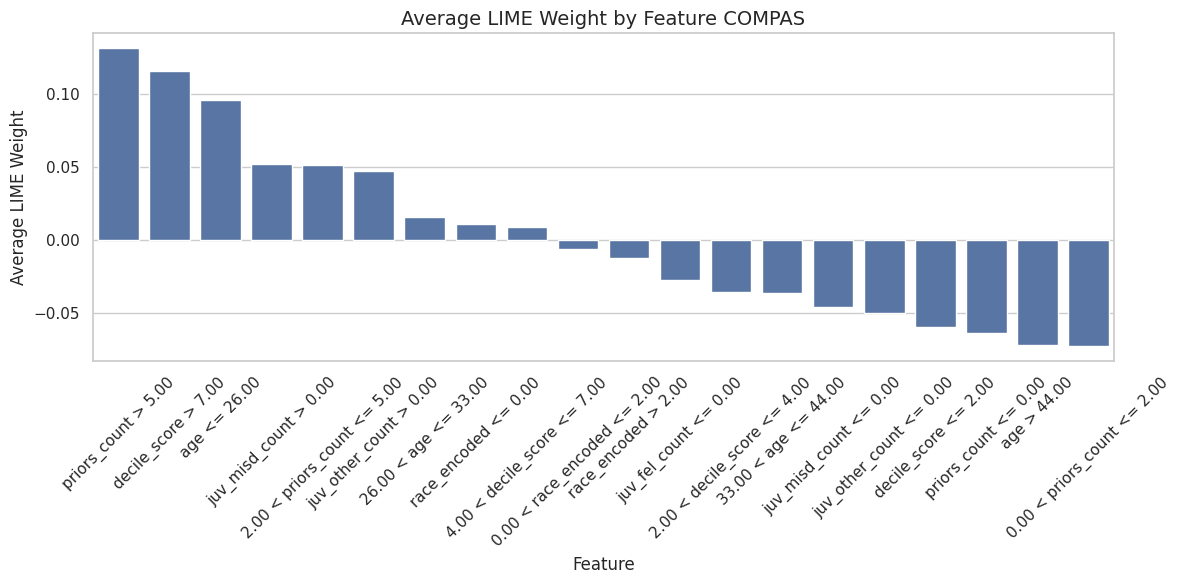

In [19]:
#Make bar plot of Average LIME Weights(since we want to average it rather than making graaph for each local model)
#to visualize calculate the average LIME weight per feature
avg_weights_compas=lime_df.groupby('feature')['lime_weight'].mean().reset_index()
# sort by weight
avg_weights_compas=avg_weights_compas.sort_values(by='lime_weight',ascending=False)
#plot
plt.figure(figsize=(12,6))
sns.barplot(x='feature',y='lime_weight',data=avg_weights_compas)
plt.title('Average LIME Weight by Feature COMPAS', fontsize=14)
plt.xlabel('Feature', fontsize=12)
plt.ylabel('Average LIME Weight', fontsize=12)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [20]:
# 4. Reweighing for Class Imbalance and Retraining

# Calculate sample weights for the training data to help with class imbalance.
sample_weights = compute_sample_weight(class_weight='balanced', y=Y_train_compas)

# Initialize and train a Random Forest classifier with reweighing
rf_reweighted_compas = RandomForestClassifier(max_depth=3, random_state=42)
rf_reweighted_compas.fit(X_train_compas, Y_train_compas, sample_weight=sample_weights)

# Predict on the test set with the reweighted model
y_pred_rw_compas = rf_reweighted_compas.predict(X_test_compas)

print("\nReweighted Random Forest Model Performance:")
print(classification_report(Y_test_compas, y_pred_rw_compas))
print("Confusion Matrix:")
print(confusion_matrix(Y_test_compas, y_pred_rw_compas))

# Optionally, you can re-compute fairness metrics for the reweighted model:
X_test_compas_copy['pred'] = y_pred_rw_compas

print("\nFairness Metrics by Sex (Reweighted Model):")
metrics_by_sex_rw = {}
for sex in X_test_compas_copy['sex'].unique():
    metrics_by_sex_rw[sex] = compute_metrics(X_test_compas_copy, 'sex', sex)
    print(f"{sex}: {metrics_by_sex_rw[sex]}")

print("\nFairness Metrics by Race (Reweighted Model):")
metrics_by_race_rw = {}
for race in X_test_compas_copy['race'].unique():
    metrics_by_race_rw[race] = compute_metrics(X_test_compas_copy, 'race', race)
    print(f"{race}: {metrics_by_race_rw[race]}")


Reweighted Random Forest Model Performance:
              precision    recall  f1-score   support

           0       0.86      0.74      0.79       558
           1       0.36      0.54      0.43       149

    accuracy                           0.70       707
   macro avg       0.61      0.64      0.61       707
weighted avg       0.75      0.70      0.72       707

Confusion Matrix:
[[413 145]
 [ 69  80]]

Fairness Metrics by Sex (Reweighted Model):
Female: {'FPR': np.float64(0.12666666666666668), 'FNR': np.float64(0.7222222222222222), 'TNR': np.float64(0.8733333333333333), 'TPR': np.float64(0.2777777777777778)}
Male: {'FPR': np.float64(0.3088235294117647), 'FNR': np.float64(0.42748091603053434), 'TNR': np.float64(0.6911764705882353), 'TPR': np.float64(0.5725190839694656)}

Fairness Metrics by Race (Reweighted Model):
African-American: {'FPR': np.float64(0.39114391143911437), 'FNR': np.float64(0.33695652173913043), 'TNR': np.float64(0.6088560885608856), 'TPR': np.float64(0.66304347

In [21]:
#Reweighing the class to improve the class imbalance for better prediction
# Calculate sample weights for class balance
sample_weights = compute_sample_weight(class_weight='balanced', y=Y_train_compas)

# Initialize Random Forest
rf_reweighted_compas = RandomForestClassifier(max_depth=3, random_state=42)

# Fit with reweighting
rf_reweighted_compas.fit(X_train_compas, Y_train_compas, sample_weight=sample_weights)

# Predict & evaluate
y_pred_rw_compas = rf_reweighted_compas.predict(X_test_compas)
print("Reweighted Random Forest Model:")
print(classification_report(Y_test_compas, y_pred_rw_compas))
print(confusion_matrix(Y_test_compas, y_pred_rw_compas))
#Load the reweighted model into a file
joblib.dump(rf_reweighted_compas,'rf_reweighted_compas.joblib')

Reweighted Random Forest Model:
              precision    recall  f1-score   support

           0       0.86      0.74      0.79       558
           1       0.36      0.54      0.43       149

    accuracy                           0.70       707
   macro avg       0.61      0.64      0.61       707
weighted avg       0.75      0.70      0.72       707

[[413 145]
 [ 69  80]]


['rf_reweighted_compas.joblib']

In [22]:
import shap

# SHAP for reweighing
# Use background data comes from dataset as the test data
background_compas = X_train_compas.sample(30, random_state=42).astype(float)
X_test_compas_float = X_test_compas.astype(float)

# SHAP Explainer

explainer = shap.Explainer(rf_reweighted_compas, background_compas)
shap_values = explainer(X_test_compas_float)

# Extract SHAP values for class 1 (index 1)
shap_array = shap_values.values[:, :, 1]  # Shape: [707, 8]

# Create wide-format DataFrame
shap_df_compas = pd.DataFrame(shap_array, columns=X_test_compas.columns)

# Add sample IDs for reference
shap_df_compas['sample_id'] = shap_df_compas.index

# Save wide format CSV(this can be used with Phi-2)
shap_df_compas.to_csv("shap_values_compas_wide.csv", index=False)
print("SHAP values saved (wide format) to shap_values_compas_wide.csv")

# Melt to long format for bar plot or analysis
shap_melted_compas = shap_df_compas.melt(id_vars='sample_id', var_name='feature', value_name='shap_value')

# Save melted format CSV
shap_melted_compas.to_csv("shap_values_compas_long.csv", index=False)
print("SHAP values saved (long format) to shap_values_compas_long.csv")



SHAP values saved (wide format) to shap_values_compas_wide.csv
SHAP values saved (long format) to shap_values_compas_long.csv


<ipython-input-23-22f763e13d0a>:4: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(x='feature', y='shap_value', data=shap_melted_compas, ci=None)


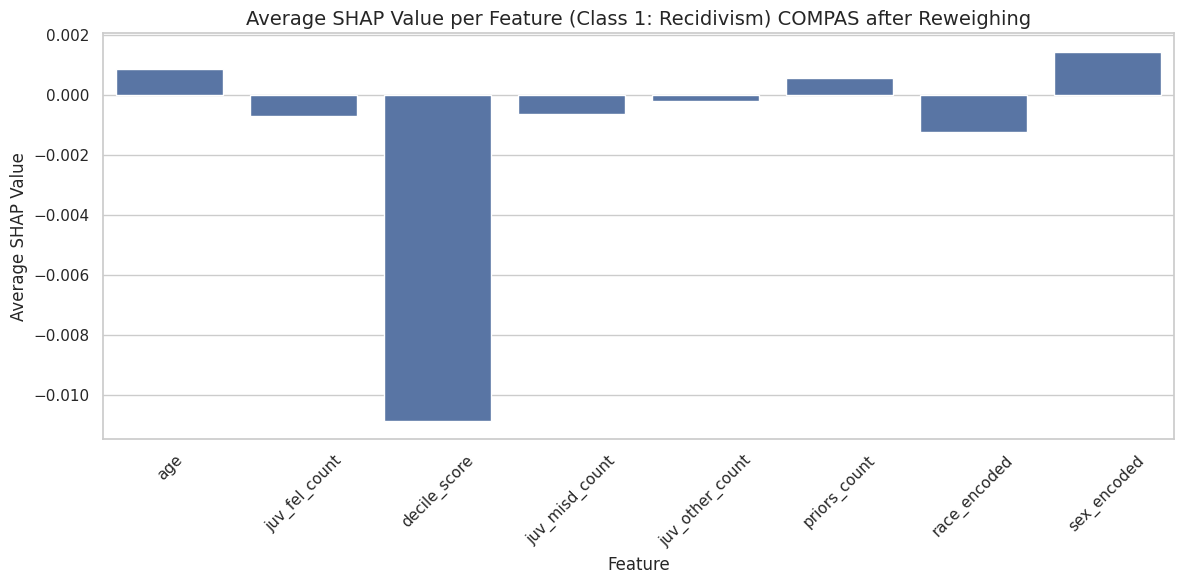

In [23]:
# Plot a bar plot of the SHAP values for each feature
plt.figure(figsize=(12, 6))
sns.set(style="whitegrid")
sns.barplot(x='feature', y='shap_value', data=shap_melted_compas, ci=None)

plt.title('Average SHAP Value per Feature (Class 1: Recidivism) COMPAS after Reweighing', fontsize=14)
plt.xlabel('Feature', fontsize=12)
plt.ylabel('Average SHAP Value', fontsize=12)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [24]:
import random
from lime.lime_tabular import LimeTabularExplainer

# Create an instance for LIME Explainer
explainer = LimeTabularExplainer(
    training_data=np.array(X_train_compas),
    feature_names=X_train_compas.columns.tolist(),
    class_names=['No Recidivism', 'Recidivism'],
    mode='classification'
)
#List to collect data
lime_data=[]
# Loop through 30 random samples from X_test_compas
for i in random.sample(range(len(X_test_compas)), 30):
    exp = explainer.explain_instance(
        data_row=X_test_compas.iloc[i],
        predict_fn=model_rf.predict_proba,
        num_features=5
    )
    for feature,weight in exp.as_list():
        lime_data.append([i,feature,weight])

# Convert to DataFrame
lime_df = pd.DataFrame(lime_data, columns=['sample_id', 'feature', 'lime_weight'])
lime_df.to_csv("lime_values_compas.csv", index=False)
print("LIME values saved to lime_values_compas.csv")


/usr/local/lib/python3.11/dist-packages/lime/discretize.py:110: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/usr/local/lib/python3.11/dist-packages/lime/discretize.py:110: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/usr/local/lib/python3.11/dist-packages/lime/lime_tabular.py:544: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.

LIME values saved to lime_values_compas.csv


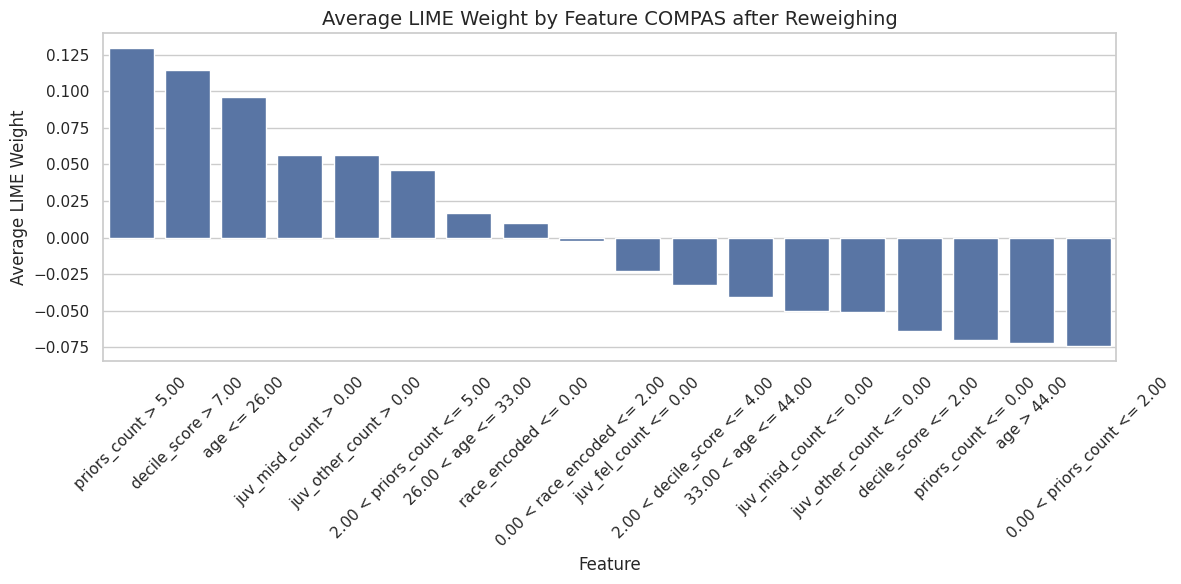

In [25]:
#Make bar plot of Average LIME Weights for COMPAS
#calculate the average LIME weight per feature
avg_weights_compas=lime_df.groupby('feature')['lime_weight'].mean().reset_index()
# sort by weight
avg_weights_compas=avg_weights_compas.sort_values(by='lime_weight',ascending=False)
#plot
plt.figure(figsize=(12,6))
sns.barplot(x='feature',y='lime_weight',data=avg_weights_compas)
plt.title('Average LIME Weight by Feature COMPAS after Reweighing', fontsize=14)
plt.xlabel('Feature', fontsize=12)
plt.ylabel('Average LIME Weight', fontsize=12)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [26]:
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.utils.class_weight import compute_sample_weight
from scipy.stats import ttest_rel

# Do 5 repeated splits
n_splits = 5
sss = StratifiedShuffleSplit(n_splits=n_splits, test_size=0.2, random_state=42)

# Lists to store TPR values across sensitive split
tpr_baseline_female_list = []
tpr_reweighted_female_list = []
tpr_baseline_African_American_list = []
tpr_reweighted_African_American_list = []

# Function to compute TPR
def compute_tpr_for_group(model, df, sensitive_col, sensitive_value):
    # Make predictions using features only
    y_pred = model.predict(df.drop(columns=['two_year_recid', 'race', 'sex']))
    df_copy = df.copy()
    df_copy['pred'] = y_pred

    group = df_copy[df_copy[sensitive_col] == sensitive_value]
    TP = ((group['two_year_recid'] == 1) & (group['pred'] == 1)).sum()
    FN = ((group['two_year_recid'] == 1) & (group['pred'] == 0)).sum()
    return TP / (TP + FN) if (TP + FN) > 0 else np.nan

for train_idx, test_idx in sss.split(df_compas_encoded, df_compas_encoded['two_year_recid']):
    df_train = df_compas_encoded.iloc[train_idx]
    df_test = df_compas_encoded.iloc[test_idx]

    # Extract features and target for training and testing
    X_train = df_train.drop(columns=['two_year_recid', 'race', 'sex'])
    y_train = df_train['two_year_recid']
    X_test = df_test.drop(columns=['two_year_recid', 'race', 'sex'])
    y_test = df_test['two_year_recid']

    # Baseline model
    model_baseline = RandomForestClassifier(random_state=42)
    model_baseline.fit(X_train, y_train)

    # Reweighted model (using sample weights)
    sample_weights = compute_sample_weight(class_weight='balanced', y=y_train)
    model_reweighted = RandomForestClassifier(max_depth=3, random_state=42)
    model_reweighted.fit(X_train, y_train, sample_weight=sample_weights)

    # Create a temporary test DataFrame including sensitive attributes and true labels
    df_test_temp = X_test.copy()
    df_test_temp['two_year_recid'] = y_test
    df_test_temp['race'] = df_test['race']
    df_test_temp['sex'] = df_test['sex']

    # Compute TPR for the "Female" group
    tpr_base_sex = compute_tpr_for_group(model_baseline, df_test_temp, sensitive_col="sex", sensitive_value="Female")
    tpr_rew_sex = compute_tpr_for_group(model_reweighted, df_test_temp, sensitive_col="sex", sensitive_value="Female")

    tpr_baseline_female_list.append(tpr_base_sex)
    tpr_reweighted_female_list.append(tpr_rew_sex)

    # Compute TPR for the "African-American" group
    tpr_base_race = compute_tpr_for_group(model_baseline, df_test_temp, sensitive_col="race", sensitive_value="African-American")
    tpr_rew_race = compute_tpr_for_group(model_reweighted, df_test_temp, sensitive_col="race", sensitive_value="African-American")

    tpr_baseline_African_American_list.append(tpr_base_race)
    tpr_reweighted_African_American_list.append(tpr_rew_race)

# Convert lists to numpy arrays
tpr_baseline_female = np.array(tpr_baseline_female_list)
tpr_reweighted_female = np.array(tpr_reweighted_female_list)
tpr_baseline_African_American = np.array(tpr_baseline_African_American_list)
tpr_reweighted_African_American = np.array(tpr_reweighted_African_American_list)

# Paired t-test for the Female group
t_stat_female, p_value_female = ttest_rel(tpr_reweighted_female, tpr_baseline_female)
print("Paired t-test for TPR in Female group:")
print("t-statistic: {:.3f}, p-value: {:.3f}".format(t_stat_female, p_value_female))
if p_value_female < 0.05:
    print("The improvement in TPR for females is statistically significant (p < 0.05).")
else:
    print("No statistically significant improvement in TPR for females (p >= 0.05).")

# Paired t-test for the African-American group
t_stat_race, p_value_race = ttest_rel(tpr_reweighted_African_American, tpr_baseline_African_American)
print("\nPaired t-test for TPR in African-American group:")
print("t-statistic: {:.3f}, p-value: {:.3f}".format(t_stat_race, p_value_race))
if p_value_race < 0.05:
    print("The improvement in TPR for African-American group is statistically significant (p < 0.05).")
else:
    print("No statistically significant improvement in TPR for African-American group (p >= 0.05).")


Paired t-test for TPR in Female group:
t-statistic: 7.408, p-value: 0.002
The improvement in TPR for females is statistically significant (p < 0.05).

Paired t-test for TPR in African-American group:
t-statistic: 24.958, p-value: 0.000
The improvement in TPR for African-American group is statistically significant (p < 0.05).


In [27]:
#Apply SLM to reduce bias and also explain both prediction and bias after training in word
# Load tokenizer and phi-2 model
tokenizer = AutoTokenizer.from_pretrained("microsoft/phi-2")
model = AutoModelForCausalLM.from_pretrained("microsoft/phi-2",
                                             torch_dtype=torch.float16,
                                             device_map="auto")

tokenizer_config.json:   0%|          | 0.00/7.34k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/798k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.11M [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/1.08k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/99.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/735 [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/35.7k [00:00<?, ?B/s]

Fetching 2 files:   0%|          | 0/2 [00:00<?, ?it/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/5.00G [00:00<?, ?B/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/564M [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

In [28]:
# Check unique features
print("Unique features in the file:", shap_melted_compas["feature"].unique())

# Adjust filter based on actual labels:
filtered_shap = shap_melted_compas[shap_melted_compas["feature"].isin(["Race", "Sex"])]

# Confirm that filtering returned rows
print("Filtered SHAP DataFrame shape:", filtered_shap.shape)


Unique features in the file: ['age' 'juv_fel_count' 'decile_score' 'juv_misd_count' 'juv_other_count'
 'priors_count' 'race_encoded' 'sex_encoded']
Filtered SHAP DataFrame shape: (0, 3)


In [29]:
import pandas as pd

def generate_shap_prompt(feature, shap_value, prediction_label, dataset_name):

    return (
        f"In the {dataset_name} dataset, the feature '{feature}' had a SHAP value of {shap_value:.2f}, "
        f"and the model predicted '{prediction_label}'. Explain in simple terms how this feature influenced the prediction, "
        f"and discuss whether it might reflect bias.\nExplanation:"
    )

def process_top_shap_features(df, dataset_name, output_csv_name, tokenizer, model, top_n=1):

    explanations = []

    # Group the data by instance_id
    grouped = df.groupby("instance_id")

    for instance_id, group in grouped:
        # Select top_n features based on absolute SHAP value
        top_features = group.reindex(group["shap_value"].abs().sort_values(ascending=False).index)[:top_n]
        for idx, row in top_features.iterrows():
            try:
                prompt = generate_shap_prompt(
                    row["feature"], row["shap_value"], row["prediction_label"], dataset_name
                )
                inputs = tokenizer(prompt, return_tensors="pt").to(model.device)
                outputs = model.generate(
                    **inputs,
                    max_length=150,
                    temperature=0.4,
                    top_p=0.9,
                    do_sample=True
                )
                full_output = tokenizer.decode(outputs[0], skip_special_tokens=True)
                explanation_only = full_output[len(prompt):].strip()

                explanations.append({
                    "instance_id": instance_id,
                    "feature": row["feature"],
                    "shap_value": row["shap_value"],
                    "prediction_label": row["prediction_label"],
                    "dataset": dataset_name,
                    "explanation": explanation_only
                })

                print(f"[{dataset_name}] Processed instance {instance_id} for feature '{row['feature']}'.")
            except Exception as e:
                print(f"Error processing instance {instance_id}, feature {row['feature']}: {e}")

    # Save the generated explanations to CSV
    results_df = pd.DataFrame(explanations)
    results_df.to_csv(output_csv_name, index=False)
    print(f"All top SHAP explanations saved to {output_csv_name}")


# Load the CSV file with top SHAP features
shap_compas = pd.read_csv("shap_values_compas_long.csv")
shap_compas=shap_melted_compas.rename(columns={"sample_id": "instance_id"})
# Define possible labels
possible_labels = ["Recidivism", "No Recidivism"]

# Assign a random label from the possible labels
shap_compas["prediction_label"] = np.random.choice(possible_labels, size=len(shap_compas))

# Create an instance_id column if it doesn't exist
if "instance_id" not in shap_compas.columns:
    shap_compas["instance_id"] = shap_compas.index



# Process the entire SHAP DataFrame to generate explanations
process_top_shap_features(
    df=shap_compas.head(30),
    dataset_name="COMPAS",
    output_csv_name="shap_values_compas_all.csv",
    tokenizer=tokenizer,
    model=model,
    top_n=4
)

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


[COMPAS] Processed instance 0 for feature 'age'.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


[COMPAS] Processed instance 1 for feature 'age'.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


[COMPAS] Processed instance 2 for feature 'age'.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


[COMPAS] Processed instance 3 for feature 'age'.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


[COMPAS] Processed instance 4 for feature 'age'.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


[COMPAS] Processed instance 5 for feature 'age'.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


[COMPAS] Processed instance 6 for feature 'age'.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


[COMPAS] Processed instance 7 for feature 'age'.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


[COMPAS] Processed instance 8 for feature 'age'.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


[COMPAS] Processed instance 9 for feature 'age'.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


[COMPAS] Processed instance 10 for feature 'age'.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


[COMPAS] Processed instance 11 for feature 'age'.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


[COMPAS] Processed instance 12 for feature 'age'.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


[COMPAS] Processed instance 13 for feature 'age'.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


[COMPAS] Processed instance 14 for feature 'age'.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


[COMPAS] Processed instance 15 for feature 'age'.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


[COMPAS] Processed instance 16 for feature 'age'.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


[COMPAS] Processed instance 17 for feature 'age'.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


[COMPAS] Processed instance 18 for feature 'age'.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


[COMPAS] Processed instance 19 for feature 'age'.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


[COMPAS] Processed instance 20 for feature 'age'.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


[COMPAS] Processed instance 21 for feature 'age'.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


[COMPAS] Processed instance 22 for feature 'age'.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


[COMPAS] Processed instance 23 for feature 'age'.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


[COMPAS] Processed instance 24 for feature 'age'.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


[COMPAS] Processed instance 25 for feature 'age'.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


[COMPAS] Processed instance 26 for feature 'age'.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


[COMPAS] Processed instance 27 for feature 'age'.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


[COMPAS] Processed instance 28 for feature 'age'.
[COMPAS] Processed instance 29 for feature 'age'.
All top SHAP explanations saved to shap_values_compas_all.csv


In [ ]:
print("Unique features:", shap_compas["feature"].unique())


In [ ]:
# Define the sensitive features you want to focus on
sensitive_features = ["race_encoded", "sex_encoded"]

# Filter the DataFrame to include only rows where the feature is one of the sensitive features
sensitive_shap = shap_compas[shap_compas["feature"].isin(sensitive_features)].copy()

# Define your possible labels for binary outcomes
possible_labels = ["Recidivism", "No Recidivism"]

# Assign a random label from the possible labels to each row in the filtered DataFrame
sensitive_shap["prediction_label"] = np.random.choice(possible_labels, size=len(sensitive_shap))

# Process the filtered dataFrame to generate natural language explanations for sensitive features
process_top_shap_features(
    df=sensitive_shap.head(10),
    dataset_name="COMPAS",
    output_csv_name="shap_values_compas_sensitive.csv",
    tokenizer=tokenizer,
    model=model,
    top_n=3
)


In [ ]:
import pandas as pd


def generate_lime_prompt(feature, impact, prediction_label, dataset_name):

    return (
        f"In the {dataset_name} dataset, the feature '{feature}' had an impact score of {impact:.2f} "
        f"on the prediction '{prediction_label}'. Explain in simple terms how this feature influenced the prediction, "
        f"and discuss any potential bias associated with it.\nExplanation:"
    )

def process_top_lime_features(df, dataset_name, output_csv_name, tokenizer, model, top_n=1):

    explanations = []

    # Group the data by instance_id
    grouped = df.groupby("instance_id")

    for instance_id, group in grouped:
        # Select top_n features based on absolute impact value
        top_features = group.reindex(group["impact"].abs().sort_values(ascending=False).index)[:top_n]
        for idx, row in top_features.iterrows():
            try:
                prompt = generate_lime_prompt(
                    row["feature"], row["impact"], row["prediction_label"], dataset_name
                )
                inputs = tokenizer(prompt, return_tensors="pt").to(model.device)
                outputs = model.generate(
                    **inputs,
                    max_length=150,
                    temperature=0.7,
                    top_p=0.9,
                    do_sample=True
                )
                full_output = tokenizer.decode(outputs[0], skip_special_tokens=True)
                explanation_only = full_output[len(prompt):].strip()

                explanations.append({
                    "instance_id": instance_id,
                    "feature": row["feature"],
                    "impact": row["impact"],
                    "prediction_label": row["prediction_label"],
                    "dataset": dataset_name,
                    "explanation": explanation_only
                })

                print(f"[{dataset_name}] Processed instance {instance_id} for feature '{row['feature']}'.")
            except Exception as e:
                print(f"Error processing instance {instance_id}, feature {row['feature']}: {e}")

    # Save the generated explanations to CSV
    results_df = pd.DataFrame(explanations)
    results_df.to_csv(output_csv_name, index=False)
    print(f"All top LIME explanations saved to {output_csv_name}")


# Load the CSV file with LIME top features
lime_compas = pd.read_csv("lime_values_compas.csv")
lime_compas = lime_compas.rename(columns={"sample_id": "instance_id", "lime_weight": "impact"})
# Rename 'sample_id' to 'instance_id'
lime_compas = lime_compas.rename(columns={"sample_id": "instance_id"})

# Add a dummy prediction_label
lime_compas["prediction_label"] = "Recidivism"

# Process a small sample  to generate explanations
process_top_lime_features(
    df=lime_compas.head(10),
    dataset_name="COMPAS",
    output_csv_name="lime_values_compas_final.csv",
    tokenizer=tokenizer,
    model=model,
    top_n=3
)


In [ ]:
#Load the adult dataset
df_adult = pd.read_csv('/content/drive/MyDrive/NCUR/adult.csv')
df_adult.head()

In [ ]:
#Read the adult.csv file
df_adult.info()

In [ ]:
df_adult.describe()

In [ ]:
#Drop column
columns_to_drop_adult=['fnlwgt','capital-gain','capital-loss','native-country','education','relationship']
df_adult=df_adult.drop(columns=columns_to_drop_adult)

In [ ]:
#Check for duplicates before dropping it
df_adult.duplicated().sum()

In [ ]:
df_adult.to_csv('cleaned_adult.csv',index=False)
df_adult_cleaned = df_adult.copy()

In [ ]:
df_adult_cleaned.info()
df_adult_cleaned.describe(include="all")

In [ ]:
# Check for any '?' entries
for col in df_adult_cleaned.columns:
    print(f"{col}: {(df_adult_cleaned[col] == '?').sum()} ")
# Count '?' in workclass and occupation by gender
for col in ['workclass', 'occupation']:
    # Filter the DataFrame for rows where the specified column has '?'
    missing_rows = df_adult_cleaned[df_adult_cleaned[col] == '?']
    # Get the value counts of 'gender' in the filtered rows
    missing_by_gender = missing_rows['gender'].value_counts()
    print(f"\nMissing '{col}' entries by gender:\n{missing_by_gender}")


In [ ]:
#Drop the workclass and occupation columns since the difference is negligible in gender
columns_to_drop_adult=['workclass','occupation']
df_adult_cleaned=df_adult_cleaned.drop(columns=columns_to_drop_adult)
print(df_adult_cleaned.info())

In [ ]:
#Encoding the adult dataset next
#Make a copy of the cleaned adult
df_adult_cleaned=df_adult_cleaned.copy()

#map the encoding to use fairness analysis

gender_mapping={'Female':0,'Male':1}
income_mapping={'<=50K':0,'>50K':1}

race_mapping_adult = {
    'Black': 0,
    'White': 1,
    'Asian-Pac-Islander': 2,
    'Amer-Indian-Eskimo': 3,
    'Other': 4
}

df_adult_cleaned['gender_encoded']=df_adult_cleaned['gender'].map(gender_mapping)
df_adult_cleaned['income_encoded']=df_adult_cleaned['income'].map(income_mapping)
df_adult_cleaned['race_encoded']=df_adult_cleaned['race'].map(race_mapping_adult)

#One-Hot Encoding multi-class categorical columns
df_adult_cleaned=pd.get_dummies(df_adult_cleaned,columns=['marital-status'])

df_adult_cleaned.to_csv('adult_encoded.csv', index=False)
df_adult_encoded = df_adult_cleaned.copy()
df_adult_encoded.head()

In [ ]:
#Check if they are actually encoded or not
df_adult_encoded['gender_encoded'].unique()

In [ ]:
df_adult_encoded['income_encoded'].unique()

In [ ]:
df_adult_encoded['race_encoded'].unique()

In [ ]:
#Split the dataset into to train and test split then train
#Perform logisitc regression on adult dataset
X_adult=df_adult_encoded.drop(columns=['income','race','gender','income_encoded'])
Y_adult=df_adult_encoded['income_encoded']
X_train_adult,X_test_adult,Y_train_adult,Y_test_adult=train_test_split(X_adult,Y_adult,test_size=0.2,random_state=42)
model_lr=LogisticRegression(max_iter=1000)
model_lr.fit(X_train_adult,Y_train_adult)
y_pred_lg=model_lr.predict(X_test_adult)

In [ ]:
#Evaluate the performance
print(classification_report(Y_test_adult,y_pred_lg))
print(confusion_matrix(Y_test_adult,y_pred_lg))

In [ ]:
#Train the model with XGBoost Classifier
X_adult=df_adult_encoded.drop(columns=['income','race','gender','income_encoded'])
Y_adult=df_adult_encoded['income_encoded']
X_train_adult,X_test_adult,Y_train_adult,Y_test_adult=train_test_split(X_adult,Y_adult,test_size=0.2,random_state=42)
model_xg=XGBClassifier(max_depth=3, learning_rate=0.1, n_estimators=100, random_state=42)
model_xg.fit(X_train_adult,Y_train_adult)
y_pred_xg=model_xg.predict(X_test_adult)

In [ ]:
#Evaluate the performance fo xg booster
print(classification_report(Y_test_adult,y_pred_xg))
print(confusion_matrix(Y_test_adult,y_pred_xg))

In [ ]:
#Apply same thing for the adult dataset
import pandas as pd

def compute_metrics(df, sensitive_column, sensitive_value):
    """
    Compute fairness metrics for a subgroup.
    """
    group = df[df[sensitive_column] == sensitive_value]

    # Calculate confusion matrix components
    TP = ((group['true'] == 1) & (group['pred'] == 1)).sum()
    TN = ((group['true'] == 0) & (group['pred'] == 0)).sum()
    FP = ((group['true'] == 0) & (group['pred'] == 1)).sum()
    FN = ((group['true'] == 1) & (group['pred'] == 0)).sum()

    # Calculate metrics with checks to avoid division by zero
    fpr = FP / (FP + TN) if (FP + TN) > 0 else None
    fnr = FN / (FN + TP) if (FN + TP) > 0 else None
    tnr = TN / (TN + FP) if (TN + FP) > 0 else None
    tpr = TP / (TP + FN) if (TP + FN) > 0 else None

    return {'FPR': fpr, 'FNR': fnr, 'TNR': tnr, 'TPR': tpr}

# Prepare the Adult test set with sensitive attributes

# Create a copy of the test features
X_test_adult_copy = X_test_adult.copy()

# Attach the true labels and model predictions
X_test_adult_copy['true'] = Y_test_adult
X_test_adult_copy['pred'] = y_pred_xg

# Re-attach sensitive attributes
X_test_adult_copy['race'] = df_adult_cleaned.loc[X_test_adult.index, 'race']
X_test_adult_copy['gender'] = df_adult_cleaned.loc[X_test_adult.index, 'gender']

# Compute fairness metrics for each subgroup by gender
print("Fairness Metrics by Gender:")
gender_groups = X_test_adult_copy['gender'].unique()
metrics_by_gender = {}
for gender in gender_groups:
    metrics_by_gender[gender] = compute_metrics(X_test_adult_copy, 'gender', gender)
    print(f"{gender}: {metrics_by_gender[gender]}")

# Compute fairness metrics for each subgroup by race
print("\nFairness Metrics by Race:")
race_groups = X_test_adult_copy['race'].unique()
metrics_by_race = {}
for race in race_groups:
    metrics_by_race[race] = compute_metrics(X_test_adult_copy, 'race', race)
    print(f"{race}: {metrics_by_race[race]}")

# Additional Analysis
fp_by_race = X_test_adult_copy[(X_test_adult_copy['true'] == 0) & (X_test_adult_copy['pred'] == 1)]['race'].value_counts(normalize=True)
fn_by_race = X_test_adult_copy[(X_test_adult_copy['true'] == 1) & (X_test_adult_copy['pred'] == 0)]['race'].value_counts(normalize=True)

print("\nFalse Positives by Race :")
print(fp_by_race)
print("\nFalse Negatives by Race:")
print(fn_by_race)

# Similarly, for gender:
fp_by_gender = X_test_adult_copy[(X_test_adult_copy['true'] == 0) & (X_test_adult_copy['pred'] == 1)]['gender'].value_counts(normalize=True)
fn_by_gender = X_test_adult_copy[(X_test_adult_copy['true'] == 1) & (X_test_adult_copy['pred'] == 0)]['gender'].value_counts(normalize=True)

print("\nFalse Positives by Gender:")
print(fp_by_gender)
print("\nFalse Negatives by Gender:")
print(fn_by_gender)


In [ ]:
#Work on the SHAP values for the adult dataset
# Sample background data
background_adult = X_train_adult.sample(30, random_state=42).astype(float)
X_test_adult_float = X_test_adult.astype(float)

# Initialize SHAP Explainer
explainer = shap.Explainer(model_xg, background_adult)

# Compute SHAP values
shap_values = explainer(X_test_adult_float)

# Extract SHAP values
shap_values_class1_adult = shap_values.values

# Confirm shapes match
print(shap_values_class1_adult.shape)
print(X_test_adult.columns.shape)

# Convert to DataFrame
shap_df_adult = pd.DataFrame(shap_values_class1_adult, columns=X_test_adult.columns)
shap_df_adult['sample_id'] = shap_df_adult.index

# Melt for seaborn plot so we can visulaize it
shap_melted_adult = shap_df_adult.melt(id_vars='sample_id', var_name='feature', value_name='shap_value')
# SHAP Summary Plot
shap.summary_plot(shap_values, X_test_adult, plot_type="bar", show=True)


In [ ]:
#Apply the LIME for adult dataset too
# Convert to numpy arrays
X_train_np = X_train_adult.values
X_test_np = X_test_adult.values
feature_names = X_train_adult.columns.tolist()
class_names = ['<=50K', '>50K']

# Initialize LIME Explainer
explainer = lime.lime_tabular.LimeTabularExplainer(
    training_data=X_train_np,
    feature_names=feature_names,
    class_names=class_names,
    mode='classification',
    discretize_continuous=True
)

# All the LIME weights into a list
lime_weights_list = []

# Loop over samples from test set
N = 30
for i in range(N):
    exp = explainer.explain_instance(
        data_row=X_test_np[i],
        predict_fn=model_xg.predict_proba,
        num_features=10
    )

    # Get explanation
    for feature, weight in exp.as_list():
        lime_weights_list.append({'feature': feature, 'lime_weight': weight})

# Convert to DataFrame
lime_df = pd.DataFrame(lime_weights_list)

# Group by feature and calculate average weight
avg_weights_adult = lime_df.groupby('feature')['lime_weight'].mean().reset_index()
avg_weights_adult = avg_weights_adult.sort_values(by='lime_weight', ascending=False)

# Plot average LIME weight per feature
plt.figure(figsize=(12, 6))
sns.barplot(x='feature', y='lime_weight', data=avg_weights_adult)
plt.title('Average LIME Weight by Feature (Adult Dataset)', fontsize=14)
plt.xlabel('Feature', fontsize=12)
plt.ylabel('Average LIME Weight', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


In [ ]:
#Reweighing for the ADULT dataset
# Calculate sample weights
sample_weights = compute_sample_weight(class_weight='balanced', y=Y_train_adult)

# Fit model with sample weights
model_xg_reweighted = XGBClassifier(max_depth=3, learning_rate=0.1, n_estimators=100, random_state=42)
model_xg_reweighted.fit(X_train_adult, Y_train_adult, sample_weight=sample_weights)

# Predict and Evaluate
y_pred_rw_adult = model_xg_reweighted.predict(X_test_adult)
print("Reweighted Model for Adult dataset:")
print(classification_report(Y_test_adult, y_pred_rw_adult))
print("Confusion Matrix:")
print(confusion_matrix(Y_test_adult, y_pred_rw_adult))

# Optionally, you can re-compute fairness metrics for the reweighted model:
X_test_adult_copy['pred'] = y_pred_rw_adult

print("\nFairness Metrics by Gender (Reweighted Model):")
metrics_by_gender_rw = {}
for sex in X_test_adult_copy['gender'].unique():
    metrics_by_gender_rw[gender] = compute_metrics(X_test_adult_copy, 'gender', gender)
    print(f"{gender}: {metrics_by_gender_rw[gender]}")

print("\nFairness Metrics by Race (Reweighted Model):")
metrics_by_race_rw = {}
for race in X_test_adult_copy['race'].unique():
    metrics_by_race_rw[race] = compute_metrics(X_test_adult_copy, 'race', race)
    print(f"{race}: {metrics_by_race_rw[race]}")

In [ ]:
#SHAP after reweighing the values for Adult dataset

# Background for SHAP
background_adult = X_train_adult.sample(50, random_state=42).astype(float)
X_test_adult_float = X_test_adult.astype(float)

# SHAP Explainer after Reweighing
explainer = shap.Explainer(model_xg_reweighted, background_adult)
shap_values = explainer(X_test_adult_float)

# SHAP Summary Plot
shap.summary_plot(shap_values, X_test_adult, plot_type="bar", show=True)


In [ ]:
#Save reweighted SHAP values in dataframe then csv for later
import pandas as pd

# Extract SHAP values
shap_array = shap_values.values

# Convert to DataFrame with feature names
shap_df = pd.DataFrame(shap_array, columns=X_test_adult.columns)

# Add prediction and true labels for context
shap_df["prediction"] = model_xg_reweighted.predict(X_test_adult)
shap_df["true_label"] = Y_test_adult.values
#Convert it to csv
shap_df.to_csv("shap_values_adult.csv", index=False)
print("SHAP values saved to shap_values_adult.csv")


In [ ]:
#LIME after reweighing
explainer = lime.lime_tabular.LimeTabularExplainer(
    training_data=X_train_adult.values,
    feature_names=X_train_adult.columns.tolist(),
    class_names=['<=50K', '>50K'],
    mode='classification'
)

lime_weights = []
for i in range(30):
    exp = explainer.explain_instance(
        data_row=X_test_adult.values[i],
        predict_fn=model_xg_reweighted.predict_proba,
        num_features=10
    )
    for feature, weight in exp.as_list():
        lime_weights.append({'feature': feature, 'lime_weight': weight})

lime_df = pd.DataFrame(lime_weights)
avg_weights = lime_df.groupby('feature')['lime_weight'].mean().reset_index()

# Plot
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(12,6))
sns.barplot(x='feature', y='lime_weight', data=avg_weights.sort_values('lime_weight', ascending=False))
plt.title('Average LIME Weight per Feature (Post-Mitigation)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [ ]:
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.utils.class_weight import compute_sample_weight
from scipy.stats import ttest_rel


# Do 5 repeated splits
n_splits = 5
sss = StratifiedShuffleSplit(n_splits=n_splits, test_size=0.2, random_state=42)

# Lists to store TPR values across splits
tpr_baseline_female_list = []
tpr_reweighted_female_list = []
tpr_baseline_Black_list = []
tpr_reweighted_Black_list = []

# Function to compute TPR from a DataFrame
def compute_tpr_for_group_adult(model, df, sensitive_col, sensitive_value):
    # Make predictions using features only
    y_pred = model.predict(df.drop(columns=['income', 'race', 'gender']))
    # Create a copy to avoid modifying the original DataFrame
    df_copy = df.copy()
    df_copy['pred'] = y_pred
    # Select the subgroup based on the sensitive attribute
    group = df_copy[df_copy[sensitive_col] == sensitive_value]


    TP = ((group['income'] == 1) & (group['pred'] == 1)).sum()
    FN = ((group['income'] == 1) & (group['pred'] == 0)).sum()
    return TP / (TP + FN) if (TP + FN) > 0 else np.nan

# Loop through repeated splits
for train_idx, test_idx in sss.split(df_adult_encoded, df_adult_encoded['income']):
    df_train = df_adult_encoded.iloc[train_idx]
    df_test = df_adult_encoded.iloc[test_idx]

    # Extract features and target for training and testing
    X_train = df_train.drop(columns=['income', 'race', 'gender'])
    y_train = df_train['income_encoded']  # Assuming this is the numeric encoding of income
    X_test = df_test.drop(columns=['income', 'race', 'gender'])
    y_test = df_test['income_encoded']

    # Baseline model training
    model_baseline = XGBClassifier(random_state=42)
    model_baseline.fit(X_train, y_train)

    # Reweighted model training using sample weights
    sample_weights = compute_sample_weight(class_weight='balanced', y=y_train)
    model_reweighted = XGBClassifier(max_depth=3, random_state=42)
    model_reweighted.fit(X_train, y_train, sample_weight=sample_weights)

    # Create a temporary test DataFrame including sensitive attributes and true labels
    df_test_temp = X_test.copy()
    df_test_temp['income'] = y_test  # Note: this column is used as the true label
    df_test_temp['race'] = df_test['race']
    df_test_temp['gender'] = df_test['gender']

    # Compute TPR for the "Female" group
    tpr_base_gender = compute_tpr_for_group_adult(model_baseline, df_test_temp, sensitive_col="gender", sensitive_value="Female")
    tpr_rew_gender = compute_tpr_for_group_adult(model_reweighted, df_test_temp, sensitive_col="gender", sensitive_value="Female")

    tpr_baseline_female_list.append(tpr_base_gender)
    tpr_reweighted_female_list.append(tpr_rew_gender)

    # Compute TPR for the "Black" group
    tpr_base_race = compute_tpr_for_group_adult(model_baseline, df_test_temp, sensitive_col="race", sensitive_value="Black")
    tpr_rew_race = compute_tpr_for_group_adult(model_reweighted, df_test_temp, sensitive_col="race", sensitive_value="Black")

    tpr_baseline_Black_list.append(tpr_base_race)
    tpr_reweighted_Black_list.append(tpr_rew_race)

# Convert lists to numpy arrays
tpr_baseline_female = np.array(tpr_baseline_female_list)
tpr_reweighted_female = np.array(tpr_reweighted_female_list)
tpr_baseline_Black = np.array(tpr_baseline_Black_list)
tpr_reweighted_Black = np.array(tpr_reweighted_Black_list)

# Paired t-test for the Female group
t_stat_female, p_value_female = ttest_rel(tpr_reweighted_female, tpr_baseline_female)
print("Paired t-test for TPR in Female group:")
print("t-statistic: {:.3f}, p-value: {:.3f}".format(t_stat_female, p_value_female))
if p_value_female < 0.05:
    print("The improvement in TPR for females is statistically significant (p < 0.05).")
else:
    print("No statistically significant improvement in TPR for females (p >= 0.05).")

# Paired t-test for the Black group
t_stat_race, p_value_race = ttest_rel(tpr_reweighted_Black, tpr_baseline_Black)
print("\nPaired t-test for TPR in Black group:")
print("t-statistic: {:.3f}, p-value: {:.3f}".format(t_stat_race, p_value_race))
if p_value_race < 0.05:
    print("The improvement in TPR for Black group is statistically significant (p < 0.05).")
else:
    print("No statistically significant improvement in TPR for Black group (p >= 0.05).")


In [ ]:
print("Columns in shap_adult:", shap_df_adult.columns)


In [ ]:
import pandas as pd
import numpy as np

# Load your wide-format CSV file
shap_adult = pd.read_csv("shap_values_adult.csv")



# Rename 'sample_id' to 'instance_id' if it exists
if "sample_id" in shap_adult.columns:
    shap_adult = shap_adult.rename(columns={"sample_id": "instance_id"})

# If 'instance_id' still does not exist, create it from the index
if "instance_id" not in shap_adult.columns:
    shap_adult["instance_id"] = shap_adult.index

# Assign random prediction labels for testing:
possible_labels = ["Income>=50k", "Income<=50k"]
shap_adult["prediction_label"] = np.random.choice(possible_labels, size=len(shap_adult))

# Define id_vars for the melt operation.
id_vars = ["instance_id", "prediction", "true_label", "prediction_label"]

# Identify feature columns by excluding id_vars.
feature_columns = [col for col in shap_adult.columns if col not in id_vars]

# Melt the DataFrame: this creates two new columns "feature" and "shap_value"
melted_shap_adult = shap_adult.melt(
    id_vars=["instance_id", "prediction_label"],
    value_vars=feature_columns,
    var_name="feature",
    value_name="shap_value"
)

# Check the result
print("Melted DataFrame columns:", melted_shap_adult.columns)
print(melted_shap_adult.head())

# Now you can call your process_top_shap_features function on a subset
process_top_shap_features(
    df=melted_shap_adult.head(30),
    dataset_name="Adult",
    output_csv_name="shap_values_adult_all.csv",
    tokenizer=tokenizer,
    model=model,
    top_n=4
)


In [ ]:
#Do the same generation for sensitive dataset
# Define the sensitive features you want to focus on
sensitive_features = ["race_encoded", "gender_encoded"]

# Filter the DataFrame to include only rows where the feature is one of the sensitive features
sensitive_shap = shap_compas[shap_compas["feature"].isin(sensitive_features)].copy()

# Define your possible labels for binary outcomes
possible_labels = ["Income>=50k", "Income<=50k"]

# Assign a random label from the possible labels to each row in the filtered DataFrame
sensitive_shap["prediction_label"] = np.random.choice(possible_labels, size=len(sensitive_shap))

# Process the filtered DataFrame to generate natural language explanations for sensitive features
process_top_shap_features(
    df=sensitive_shap.head(10),
    dataset_name="COMPAS",
    output_csv_name="shap_values_adult_sensitive.csv",
    tokenizer=tokenizer,
    model=model,
    top_n=3
)


In [ ]:
#Generate for LIME
# Load the CSV file with LIME top features
lime_compas = pd.read_csv("lime_values_compas.csv")
lime_compas = lime_compas.rename(columns={"sample_id": "instance_id", "lime_weight": "impact"})
# Rename 'sample_id' to 'instance_id'
lime_compas = lime_compas.rename(columns={"sample_id": "instance_id"})


# Add a dummy prediction_label

# Define your possible labels for binary outcomes
possible_labels = ["Income>=50k", "Income<=50k"]

# Assign a random label from the possible labels to each row in the filtered DataFrame
lime_compas["prediction_label"] = np.random.choice(possible_labels, size=len(lime_compas))


# Process a small sample (first 5 rows) to generate explanations
process_top_lime_features(
    df=lime_compas.head(10),
    dataset_name="COMPAS",
    output_csv_name="lime_values_compas_final.csv",
    tokenizer=tokenizer,
    model=model,
    top_n=3
)
2